In [243]:
""" Bike Sharing Demand Kaggle competition (https://www.kaggle.com/competitions/bike-sharing-demand/overview) 
Given various external conditions like temperature, day of the week, etc., predict how many bikes are going to
be rented in the future for a given hour of a given day.

Information about the data tables:

datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
"""

' Bike Sharing Demand Kaggle competition (https://www.kaggle.com/competitions/bike-sharing-demand/overview) \nGiven various external conditions like temperature, day of the week, etc., predict how many bikes are going to\nbe rented in the future for a given hour of a given day.\n\nInformation about the data tables:\n\ndatetime - hourly date + timestamp  \nseason -  1 = spring, 2 = summer, 3 = fall, 4 = winter \nholiday - whether the day is considered a holiday\nworkingday - whether the day is neither a weekend nor holiday\nweather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy\n2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist\n3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds\n4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog \ntemp - temperature in Celsius\natemp - "feels like" temperature in Celsius\nhumidity - relative humidity\nwindspeed - wind speed\ncasual - number of non-registered user rentals initiated\n

In [244]:
%reset -f
# imports
from importlib import reload
import  helper_functions as hf
reload(hf)

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

## 1. Data Cleaning & Exploratory Analysis

In [245]:
# load training data
data = pd.read_csv('./data/train.csv', index_col=0, parse_dates=True) # read 1st col as datetimeindex

In [246]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB
None


In [247]:
print(data.head(10))

                     season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-01 00:00:00       1        0           0        1   9.84  14.395   
2011-01-01 01:00:00       1        0           0        1   9.02  13.635   
2011-01-01 02:00:00       1        0           0        1   9.02  13.635   
2011-01-01 03:00:00       1        0           0        1   9.84  14.395   
2011-01-01 04:00:00       1        0           0        1   9.84  14.395   
2011-01-01 05:00:00       1        0           0        2   9.84  12.880   
2011-01-01 06:00:00       1        0           0        1   9.02  13.635   
2011-01-01 07:00:00       1        0           0        1   8.20  12.880   
2011-01-01 08:00:00       1        0           0        1   9.84  14.395   
2011-01-01 09:00:00       1        0           0        1  13.12  17.425   

                     humidity  windspeed  casual  registered  count  
datetime         

In [248]:
print(data.isna().sum())
print('The table contains no NaNs')

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
The table contains no NaNs


In [249]:
# create new feature: year, month, day of the week
data['year'] = data.index.year
data['month'] =  data.index.month
data['day'] =  data.index.dayofweek
data['hour'] =  data.index.hour

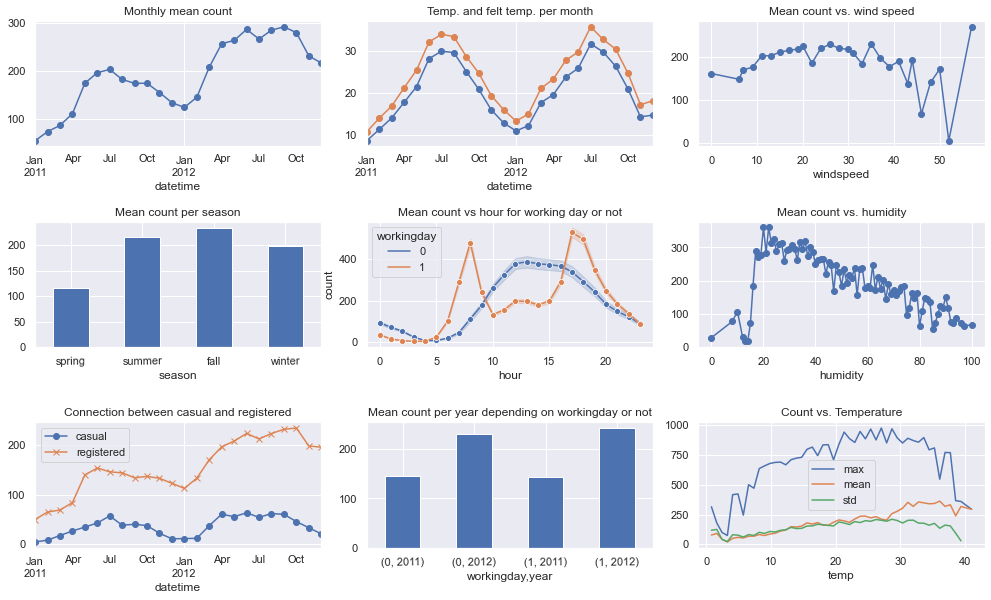

In [250]:
#EDA plots
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(14,8))
fig.tight_layout()

# avg. monthly rentals
data.resample('1m')['count'].mean().plot(ax=axes[0,0], marker='o')
ax=axes[0,0].set_title('Monthly mean count')
# avg. monthly temp and atemp
data.resample('1m')['temp'].mean().plot(ax=axes[0,1], marker='o')
data.resample('1m')['atemp'].mean().plot(ax=axes[0,1], marker='o')
ax=axes[0,1].set_title('Temp. and felt temp. per month')
# impact of windspeed on count
data.groupby('windspeed')['count'].mean().plot(ax=axes[0,2], marker='o')
ax=axes[0,2].set_title('Mean count vs. wind speed')
# histogram of rentals per season
data.groupby('season')['count'].mean().plot.bar(ax=axes[1,0], rot=1)
axes[1,0].set_xticklabels(['spring','summer','fall','winter'])  
ax=axes[1,0].set_title('Mean count per season')
# Mean count depending on holiday or not
sns.lineplot(data=data, x="hour", y="count", hue='workingday', marker='o', markers=True, ax=axes[1,1])
ax=axes[1,1].set_title('Mean count vs hour for working day or not')
# impact of humidity on count
data.groupby('humidity')['count'].mean().plot(ax=axes[1,2], marker='o')
ax=axes[1,2].set_title('Mean count vs. humidity')
# Mean count depending on workingday or not
data.groupby(['workingday','year'])['count'].mean().plot.bar(ax=axes[2,1], rot=1)
ax=axes[2,1].set_title('Mean count per year depending on workingday or not')
# correlation between casual and registered
data.resample('1m')['casual'].mean().plot(ax=axes[2,0], marker='o', legend=True)
data.resample('1m')['registered'].mean().plot(ax=axes[2,0], marker='x', legend=True)
ax=axes[2,0].set_title('Connection between casual and registered')
# avg. monthly count vs. temp.
data.groupby('temp')['count'].max().plot(ax=axes[2,2], legend=True, label='max')
data.groupby('temp')['count'].mean().plot(ax=axes[2,2], legend=True,  label='mean')
data.groupby('temp')['count'].std().plot(ax=axes[2,2], legend=True,  label='std')
ax=axes[2,2].set_title('Count vs. Temperature')

plt.subplots_adjust(hspace = 0.6)
plt.show()


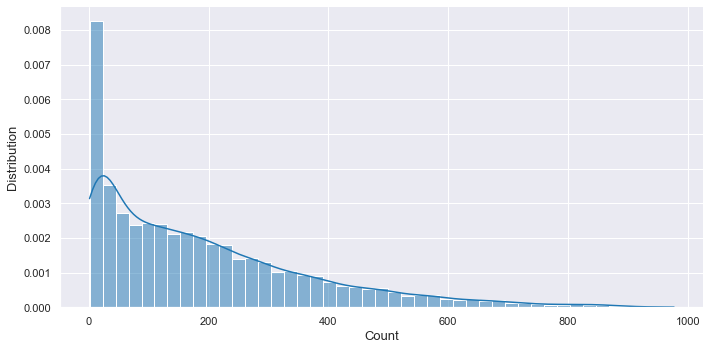

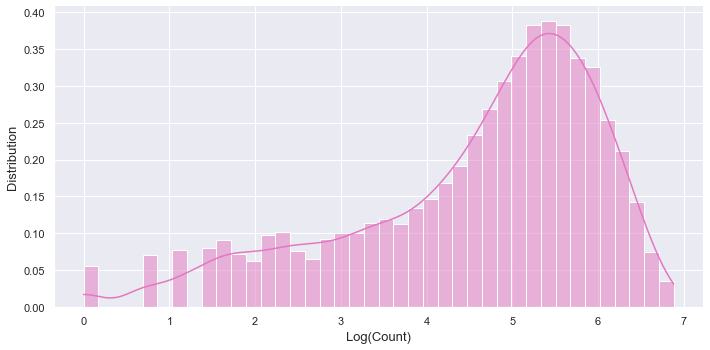

In [251]:
# total distribution of count
sns.displot(data["count"], kde=True, aspect=2, stat='density', color='tab:blue')
plt.xlabel('Count', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.show()

sns.displot(np.log(data["count"]), kde=True, aspect=2, stat='density', color='tab:pink')
plt.xlabel('Log(Count)', fontsize=13)
plt.ylabel('Distribution', fontsize=13)
plt.show()

In [252]:
""" Observations:
- temp and atemp (felt temp) are very closely correlated and one can be dropped
- the oscillating behaviour of large windspeeds should be smoothed
- season has a significant influence on bikes rented
- we can drop day and instead keep workingday as the combination workingday+hour has strong influence on count
- small oscillations in humidity should be smoothed
- the mean count is much higher in 2012 than 2011 -> year is an important feature
- registered + casual = count, therefore they need to be removed

- taking the log of the count gives a more normal distribution of the observed values
"""

' Observations:\n- temp and atemp (felt temp) are very closely correlated and one can be dropped\n- the oscillating behaviour of large windspeeds should be smoothed\n- season has a significant influence on bikes rented\n- we can drop day and instead keep workingday as the combination workingday+hour has strong influence on count\n- small oscillations in humidity should be smoothed\n- the mean count is much higher in 2012 than 2011 -> year is an important feature\n- registered + casual = count, therefore they need to be removed\n\n- taking the log of the count gives a more normal distribution of the observed values\n'

## 2. Feature Engineering

### 2.1 Feature Selection

In [253]:
# remove unnecessary features according to the observations above
data = data.drop(columns=['holiday', 'registered', 'casual', 'temp', 'day'], axis=1)

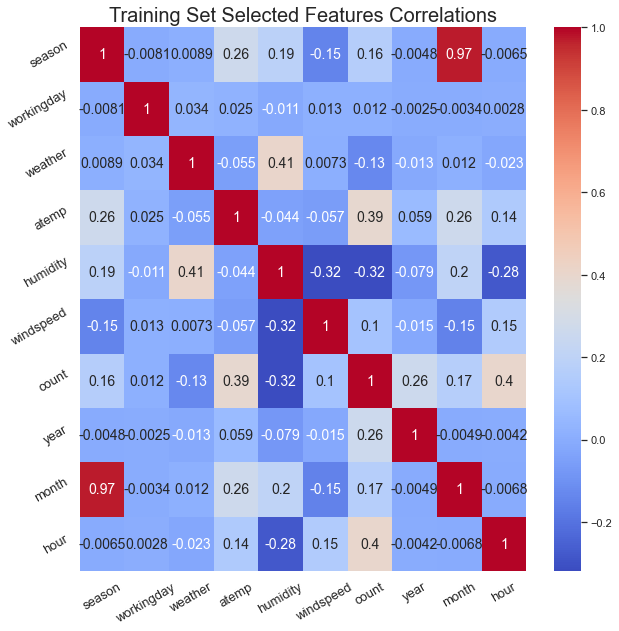

In [254]:
# feature correlation heatmap
fig, ax = plt.subplots(figsize=(10, 10))

map = sns.heatmap(data.corr(), annot=True, square=False, cmap='coolwarm', annot_kws={'rotation': 0, 'size': 14})
ax.set_title('Training Set Selected Features Correlations', size=20)
map.set_yticklabels(map.get_yticklabels(), rotation = 30, fontsize = 13)
map.set_xticklabels(map.get_yticklabels(), rotation = 30, fontsize = 13)
plt.show()

In [255]:
print('Correlation between features and bikes rented (count):')
print(data.corr()['count'].sort_values(ascending=False))


Correlation between features and bikes rented (count):
count         1.000000
hour          0.400601
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
workingday    0.011594
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64


In [256]:
x = data.corr()['count'].abs().sort_values(ascending=False).index[1:6]
print(f'The 5 most correlated features with count are: {x}')

The 5 most correlated features with count are: Index(['hour', 'atemp', 'humidity', 'year', 'month'], dtype='object')


### 2.2 Feature Transformation & Encoding

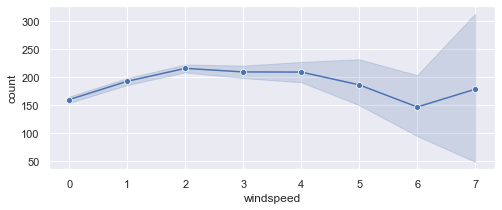

In [257]:
# smooth outliers for large windspeed by binning
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', dtype=None)
data['windspeed'] = est.fit_transform(data['windspeed'].values.reshape(-1, 1))

fig, axs = plt.subplots(figsize=(8, 3))
sns.lineplot(x=data['windspeed'], y=data['count'], marker='o')
plt.show()

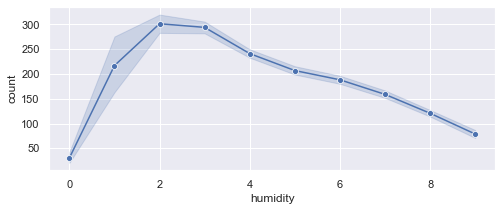

In [258]:
# smooth outliers for small humidity by binning
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data['humidity'] = est.fit_transform(data['humidity'].values.reshape(-1, 1))

fig, axs = plt.subplots(figsize=(8, 3))
sns.lineplot(x=data['humidity'], y=data['count'], marker='o')
plt.show()

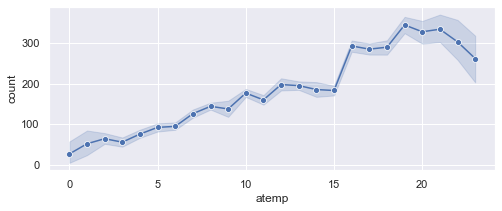

In [259]:
# slightly smooth and encode atemp
est = KBinsDiscretizer(n_bins=24, encode='ordinal', strategy='uniform')
data['atemp'] = est.fit_transform(data['atemp'].values.reshape(-1, 1))

fig, axs = plt.subplots(figsize=(8, 3))
sns.lineplot(x=data['atemp'], y=data['count'], marker='o')
plt.show()

In [260]:
# split features and target values
X = data.drop('count', axis=1)
y = np.log1p(data['count']) #+1 log to not get -inf values


In [261]:
# build preprocessing pipeline
catagorical_cols = ['year', 'month', 'hour', 'weather', 'workingday', 'season']
numerical_cols = ['atemp', 'humidity', 'windspeed']

preprocessor = ColumnTransformer([
    ("minmax", MinMaxScaler(), numerical_cols),
    ("onehot", OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore"), catagorical_cols)
], remainder='passthrough')

pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    # ("classifier", LinearRegression())
])


In [262]:
# # put a nparray back into  a dataframe
# scaler_names_out = pipe['preprocessor'].transformers_[0][1].feature_names_in_
# categorical_names_out = pipe['preprocessor'].transformers_[1][1].get_feature_names_out()
# total_cols_out = np.concatenate((scaler_names_out, categorical_names_out), axis=None)
# X = pd.DataFrame(X, columns=total_cols_out) 

## 3. Model

In [263]:
# transform and avoid information leak
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

### 3.1 Linear Regression

In [264]:
# train model
regressor = LinearRegression(fit_intercept=True, n_jobs=-1)
regressor.fit(X_train, y_train)
#predict results
y_pred = regressor.predict(X_test)

In [265]:
# check different scores
print(f'Metrics of simple linear regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {hf.calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of simple linear regression:
MSE: 0.35675432634232696
MAE: 0.4438566500578697
R2: 0.8276
Adjusted R2: 0.8239


### 3.2 Polynomial Linear Regression

In [266]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2, include_bias=False) # we put intercept in linear regression
X_poly = poly_reg.fit_transform(X)

# train model
regressor = LinearRegression(fit_intercept=True, n_jobs=-1)
regressor.fit(X_train, y_train)
#predict results
y_pred = regressor.predict(X_test)

print(f'The coefficients of polynomial model are {regressor.coef_}')


The coefficients of polynomial model are [ 9.19318188e-01 -2.97353873e-01 -1.80643299e-01  4.76206371e-01
  1.75966786e-01  2.84804388e-01  4.90785902e+09  4.90785902e+09
  4.90785902e+09 -2.65338565e+11 -2.65338565e+11 -2.65338565e+11
 -9.49415788e+10 -9.49415788e+10 -9.49415788e+10 -5.94138536e-01
 -1.11071251e+00 -1.57412289e+00 -1.88268585e+00 -9.31378299e-01
  2.58718938e-01  1.22874810e+00  1.88261581e+00  1.55274496e+00
  1.21891163e+00  1.34806695e+00  1.54244507e+00  1.51922495e+00
  1.44097961e+00  1.47791677e+00  1.74038355e+00  2.15489058e+00
  2.07663447e+00  1.77988040e+00  1.48370652e+00  1.21069653e+00
  9.65952551e-01  5.68848255e-01 -5.62471667e-02 -5.64357357e-01
 -1.60715351e-01 -6.15733399e-02 -4.90785901e+09  2.65338565e+11
  9.49415788e+10]


In [267]:
# check different scores
print(f'Metrics of polynomial linear regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {hf.calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of polynomial linear regression:
MSE: 0.35675432634232696
MAE: 0.4438566500578697
R2: 0.8276
Adjusted R2: 0.8239


### 3.3. SVR

In [268]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()

X_trans = sc_X.fit_transform(X)
y_trans = sc_y.fit_transform(y.values.reshape(-1, 1))
y_trans = np.ravel(y_trans)

# split transformed data into train and test set
X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(X_trans, y_trans, test_size=0.20, random_state=0)

# train the model
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_trans_train, y_trans_train)

# re-scale the data back
y_pred = regressor.predict(X_trans_test) # this is not inverse tranformed yet
#y_pred = y_pred.reshape(-1,1)
# now we go back
#y_pred = sc_y.inverse_transform(y_pred)

In [269]:
print(f'Metrics of SVR:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_trans_test, y_pred):4}\nR2: {metrics.r2_score(y_trans_test, y_pred):.4}\nAdjusted R2: {hf.calculate_adj_r2(y_pred, y_trans_test, X_trans_train):.4}')

Metrics of SVR:
MSE: 21.76790736487734
MAE: 0.39505139240581677
R2: 0.7041
Adjusted R2: 0.7029


### 3.4 Decision Tree Regression

In [270]:
# no feature scaling needed 
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

print(f'Metrics of decision tree regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {hf.calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of decision tree regression:
MSE: 0.33610758758939835
MAE: 0.37686182402276885
R2: 0.8375
Adjusted R2: 0.8341


### 3.5 Random Forest Regression

In [271]:
#baseline
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test) 

print(f'Metrics of random forest regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {hf.calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of random forest regression:
MSE: 0.2043394031000702
MAE: 0.3159180353532709
R2: 0.9012
Adjusted R2: 0.8991


### 3.5 Random Forest Regression with RandomizedSearchCV

In [272]:
regressor = RandomForestRegressor(random_state=0)

saved_params = {'n_estimators': 389, 'max_depth': 14, 'ccp_alpha': 0.005187860036053216}

if len(saved_params) == 0:
    regressor = regressor
    # Randomized Search of hyperparams
    distributions = dict(ccp_alpha=uniform(loc=0, scale=0.3).rvs(200),
                        max_depth=list(range(1,50,1)),
                        n_estimators=list(range(1,500,2)),
    )

    clf = RandomizedSearchCV(regressor, distributions, n_iter= 100, scoring='neg_root_mean_squared_error',
                            cv=5, verbose=1, return_train_score=True, random_state=0)

    search = clf.fit(X_train, y_train)
    best_accuracy = search.best_score_
    best_parameters = search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters

regressor = RandomForestRegressor(**saved_params)
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test) # this is not inverse tranformed yet

print(f'Metrics of decision tree regression:\nMSE: {metrics.mean_squared_error(y_test, y_pred):4}\nMAE: {metrics.mean_absolute_error(y_test, y_pred):4}\nR2: {metrics.r2_score(y_test, y_pred):.4}\nAdjusted R2: {hf.calculate_adj_r2(y_pred, y_test, X_train):.4}')

Metrics of decision tree regression:
MSE: 0.44073353495053746
MAE: 0.5010192812675416
R2: 0.787
Adjusted R2: 0.7825


### 3.6 XGBoost with RandomizedSearchCV

In [273]:
# use CV and train on whole data set without splitting
saved_params_xgb = {'booster': 'dart', 'learning_rate': 0.22758468729670714, 'max_depth': 11, 'min_child_weight': 20, 'n_estimators': 152}
saved_params_xgb = {'n_estimators': 1455, 'max_depth': 3, 'learning_rate': 0.24847460431740112, 'booster': 'gbtree'}
saved_params_xgb = {'n_estimators': 2285, 'max_depth': 2, 'learning_rate': 0.25954673732715494, 'booster': 'gbtree'} # kaggle score: 0.40

if len(saved_params_xgb) == 0:
    regressor = XGBRegressor(verbosity=0, n_jobs=4)
    # Randomized Search of hyperparams
    distributions = dict(learning_rate=uniform(loc=0, scale=0.15).rvs(200),
                        #gamma=uniform(loc=0, scale=1),
                        n_estimators=list(range(2200,5000,20)),
                        max_depth=list(range(2,4,1)),
                        booster=['gbtree'],
                        #min_child_weight=list(range(2,25,2)),
                        #reg_alpha=uniform(loc=0, scale=1),
                        #reg_lambda=uniform(loc=0, scale=3),
    )
        
    clf = RandomizedSearchCV(regressor, distributions, n_iter= 50, scoring='neg_mean_squared_error',
                            cv=5, verbose=3, return_train_score=False, random_state=0, n_jobs=4)

    search = clf.fit(X_train, y_train)
    best_accuracy = search.best_score_
    best_parameters = search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters
    comment ="xgb, usual setup"
    hf.write_params_to_file(save_switch=1, path="./output/", file_name="log_params.txt", saved_params=saved_params_xgb, best_score=best_accuracy, comment=comment)

In [274]:
## XGboost with saved params
regressor = XGBRegressor(**saved_params_xgb)
regressor = regressor.fit(X_train, y_train)
# check cross-validation
results = cross_val_score(regressor, X_train, y_train, cv=5, verbose=4, scoring='neg_mean_squared_log_error')
print(results.mean())
y_pred = regressor.predict(X_test) # this is not inverse tranformed yet
print(f'RMSLE: {metrics.mean_squared_log_error(y_test, y_pred, squared=False)}')  # RMSLE

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.007) total time=   3.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


[CV] END ............................... score: (test=-0.008) total time=   3.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV] END ............................... score: (test=-0.009) total time=   3.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s


[CV] END ............................... score: (test=-0.008) total time=   3.0s
[CV] END ............................... score: (test=-0.007) total time=   3.0s
-0.007532180924215008
RMSLE: 0.09222821509036218


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.1s finished


In [275]:
if len(saved_params_xgb) == 0: # clf only exists if we can the grid search
    df = pd.DataFrame(clf.cv_results_)
    df.sort_values('rank_test_score').head(5)

In [276]:
# draw histogram of importances of each feature
# importances = pd.DataFrame(zip(regressor.feature_importances_,regressor.feature_names_in_), columns=['Importance', 'Feature'])
# importances.sort_values(by='Importance', inplace=True, ascending=False)
# plt.figure(figsize=(40, 10))
# sns.barplot(x='Feature', y='Importance', data=importances)

### 3.7 LightGBM with RandomizedSearchCV

In [277]:
import lightgbm as lgb

# use CV and train on whole data set without splitting
saved_params = {'booster': 'gbtree', 'learning_rate': 0.03865816963989605, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 42} #-0.44
#saved_params = {'booster': 'gbtree', 'gamma': 0.44458728781130075, 'learning_rate': 0.1008306799199662, 'max_depth': 8, 'min_child_weight': 12, 'n_estimators': 14, 'reg_alpha': 0.40430652630881414, 'reg_lambda': 2.6860353417578513} # -44%
saved_params =  {'learning_rate': 0.08601500491211829, 'max_depth': 9, 'n_estimators': 47, 'num_leaves': 36}
saved_params =  {'learning_rate': 0.3196810349409567, 'max_depth': 2, 'min_child_weight': 7, 'n_estimators': 1567, 'num_leaves': 55}
#saved_params = {}

if len(saved_params) == 0:
    regressor = lgb.LGBMRegressor(random_state=0)    # Randomized Search of hyperparams
    distributions = dict(learning_rate=uniform(loc=0, scale=1),
                        num_leaves=list(range(1,150,1)),
                        n_estimators=list(range(1,2000,1)),
                        max_depth=list(range(1,100,1)),
                        min_child_weight=list(range(0,20,1)),
                        #reg_alpha=uniform(loc=0, scale=1),
                        #reg_lambda=uniform(loc=0, scale=3),
    )

    clf = RandomizedSearchCV(regressor, distributions, n_iter= 500, scoring='neg_mean_squared_error',
                            cv=5, verbose=1, return_train_score=False, random_state=0)

    search = clf.fit(X_train, y_train)
    best_accuracy = search.best_score_
    best_parameters = search.best_params_
    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)

    saved_params = best_parameters
    comment ="lgb, smooth, usual features"
    hf.write_params_to_file(save_switch=1, path="./output/", file_name="log_params.txt", saved_params=saved_params, best_score=best_accuracy, comment=comment)


In [278]:
## LGB with saved params
regressor =  lgb.LGBMRegressor(**saved_params)
regressor.fit(X_train, y_train)
# check cross-validation
results = cross_val_score(regressor, X_train, y_train, cv=5, verbose=4, scoring='neg_mean_squared_log_error')
print(results.mean())
y_pred = regressor.predict(X_test) 
print(f'RMSLE: {metrics.mean_squared_log_error(y_test, y_pred, squared=False)}')  # RMSLE

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ............................... score: (test=-0.007) total time=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] END ............................... score: (test=-0.008) total time=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] END ............................... score: (test=-0.009) total time=   0.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s


[CV] END ............................... score: (test=-0.008) total time=   0.2s
[CV] END ............................... score: (test=-0.007) total time=   0.2s
-0.007616998935792867
RMSLE: 0.09244092901101301


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [279]:
if len(saved_params) == 0: # clf only exists if we can the grid search
    df = pd.DataFrame(clf.cv_results_)
    print(df.sort_values('rank_test_score').head(5))

## 4. Kaggle Submission on Test Data Set

In [280]:
## testing has shown, that XGBoost yields the best results for this problem: apply the XGB model to test data
regressor = XGBRegressor(**saved_params_xgb)
# train on entire kaggle-test set, not the sklean split
X = pipe.fit_transform(X)
regressor = regressor.fit(X, y)

In [281]:
data_test = pd.read_csv('./data/test.csv', index_col=0, parse_dates=True) # read 1st col as datetimeindex# process columns Ticket, Age, Class
print(data_test.head(5))

                     season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

                     humidity  windspeed  
datetime                                  
2011-01-20 00:00:00        56    26.0027  
2011-01-20 01:00:00        56     0.0000  
2011-01-20 02:00:00        56     0.0000  
2011-01-20 03:00:00        56    11.0014  
2011-01-20 04:00:00        56    11.0014  


In [282]:
print(data_test.isna().sum())

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


In [283]:
print('The test table contains no NaNs')

The test table contains no NaNs


In [284]:
## perform same feature engineering as for the Training Set
# create new feature: year, month, day of the week
data_test['year'] = data_test.index.year
data_test['month'] =  data_test.index.month
data_test['day'] =  data_test.index.dayofweek
data_test['hour'] =  data_test.index.hour

In [285]:
# remove unnecessary features according to the observations above
data_test = data_test.drop(columns=['holiday', 'temp', 'day'], axis=1)

In [286]:
# smooth outliers for large windspeed by binning
est = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform', dtype=None)
data_test['windspeed'] = est.fit_transform(data_test['windspeed'].values.reshape(-1, 1))

In [287]:
# smooth outliers for small humidity by binning
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
data_test['humidity'] = est.fit_transform(data_test['humidity'].values.reshape(-1, 1))

In [288]:
# slightly smooth and encode atemp
est = KBinsDiscretizer(n_bins=24, encode='ordinal', strategy='uniform')
data_test['atemp'] = est.fit_transform(data_test['atemp'].values.reshape(-1, 1))

In [289]:
X_test = pipe.transform(data_test)

In [290]:
# make predictions based on Model chosen in 3.
y_pred_test = regressor.predict(X_test)
y_pred_test = np.expm1(y_pred_test)#convert back from log
y_pred_test= y_pred_test.round()
y_pred_test.shape

(6493,)

In [291]:
y_pred_test

array([15.,  4.,  2., ..., 95., 74., 47.], dtype=float32)

In [292]:
id_column = data_test.index

In [293]:
# write titanic kaggle .csv submission
y_pred_column = pd.DataFrame(y_pred_test, id_column, columns=['count'])
y_pred_column.to_csv('./output/solution.csv')